Travail Réalisé par :

- Antoine Le Maguet : antoine.lemaguet@free.fr
- Alexandre Mallez : alexandre.mallez@gmail.com

# Setup

**Imports**

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import load_human_locomotion_dataset, get_code_list


# Spectral feature

## Question 6

In [108]:
def autocovariance(X):
    Aucov = []
    for i in range(len(X)):
        sum_ = 0
        for j in range(len(X) - i):
            sum_ += X[j] * X[j + i]
        Aucov.append(sum_ / (len(X)))
    return Aucov

def periodogram(X, fs=1):
    X=np.array(X)
    N=len(X)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    fft_values = np.fft.rfft(X)
    Pxx = (1/(N*fs)) * np.abs(fft_values)**2
    return  freqs,Pxx



L'implémentation vient de : 

$|J(f_k)|^2 = \frac{1}{Nf_s}|\sum_{t=0}^{N-1}X_te^{-2\pi if_kt/f_s}|^2=  \frac{1}{Nf_s}|FFT(X)[k]|^2$

In [109]:
N_values = [200, 500, 1000]
n_sim = 100
sigma2=1

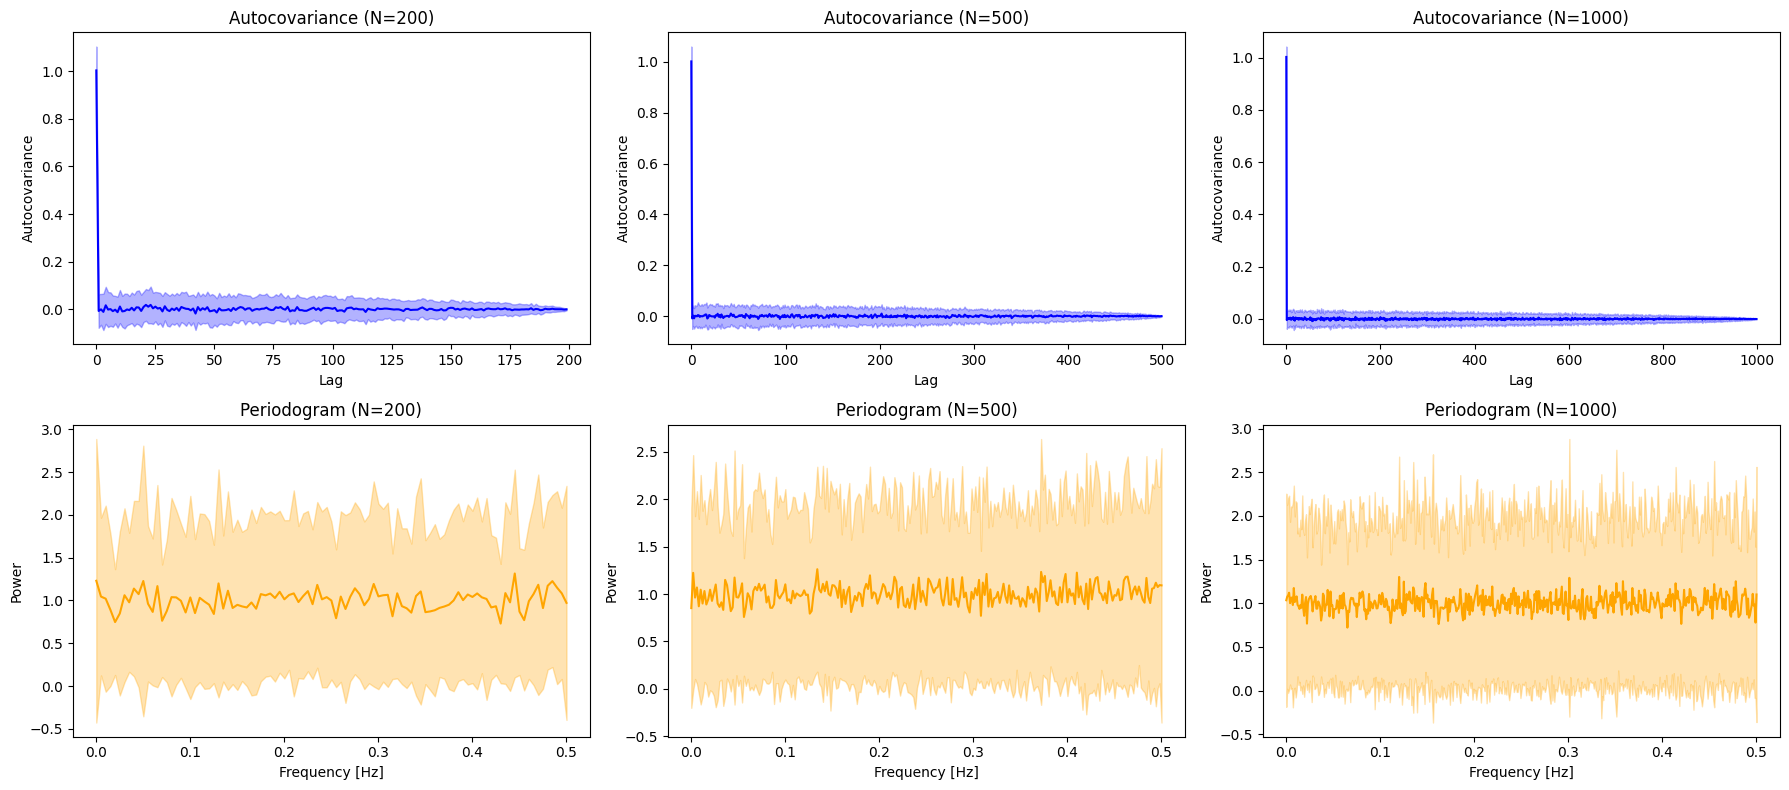

In [110]:
fig, axes = plt.subplots(2, len(N_values), figsize=(18, 8))

for i, N in enumerate(N_values):
    autocovs = []
    periodos = []

    for _ in range(n_sim):
        x = np.random.normal(0, sigma2, N)  # bruit blanc gaussien

        # Autocovariance
        acov = autocovariance(x)
        autocovs.append(acov)

        # Périodogramme
        f, Pxx = periodogram(x)
        periodos.append(Pxx)

    autocovs = np.array(autocovs)
    acov_mean = autocovs.mean(axis=0)
    acov_std = autocovs.std(axis=0)

    periodos = np.array(periodos)
    per_mean = periodos.mean(axis=0)
    per_std = periodos.std(axis=0)

    lags = np.arange(len(acov_mean))
    axes[0, i].plot(lags, acov_mean, color='blue')
    axes[0, i].fill_between(lags, acov_mean - acov_std, acov_mean + acov_std,
                            color='blue', alpha=0.3)
    axes[0, i].set_title(f"Autocovariance (N={N})")
    axes[0, i].set_xlabel("Lag")
    axes[0, i].set_ylabel("Autocovariance")


    axes[1, i].plot(f, per_mean, color='orange')
    axes[1, i].fill_between(f, per_mean - per_std, per_mean + per_std,
                            color='orange', alpha=0.3)
    axes[1, i].set_title(f"Periodogram (N={N})")
    axes[1, i].set_xlabel("Frequency [Hz]")
    axes[1, i].set_ylabel("Power")

plt.tight_layout()
plt.show()


On observe bien que l'autocovariance ressemble fortement à celle calculé en Q3 pour un bruit blanc gaussien ($\sigma^2=1$ en 0 et 0 sinon). Plus on a d'échantillon meilleur est l'estimation (ecart-type plus faible avec plus d'échantillon).

Pour le periodogramme, on a bien une moyenne au alentour de 1 constance , ce qui est cohérent avec la théorie Q3 pour un bruit blanc gaussien ($S(f)=\sigma^2=1$), cependant le periodogramme est très instable (écart type élevé et ne se stabilise pas en augmentant le nombre d'échantillon)

## Question 9

In [111]:
from scipy.signal import welch # Calcule via python la méthode de bartlett plus efficacement que la coder soit-même

On note que la méthode bartlett est un cas particulier de la méthode de welch où on il n'y a pas de chevauchement, n'y l'application de quelconque fenêtre.

On divise par 2 dans la fonction si dessous, car comme on n'affiche que dans le positif, la méthode de base double les valeurs pour prendre en compte la partie négatif.

In [112]:
def bartlett_method(X, fs=1.0, K=5):
    f, Pxx_bart = welch(X, fs=fs, nperseg=len(X)//K, noverlap=0, scaling='density')
    return f, Pxx_bart/2

In [113]:
N_values = [200, 500, 1000]
n_sim = 100
sigma2=1
K=5

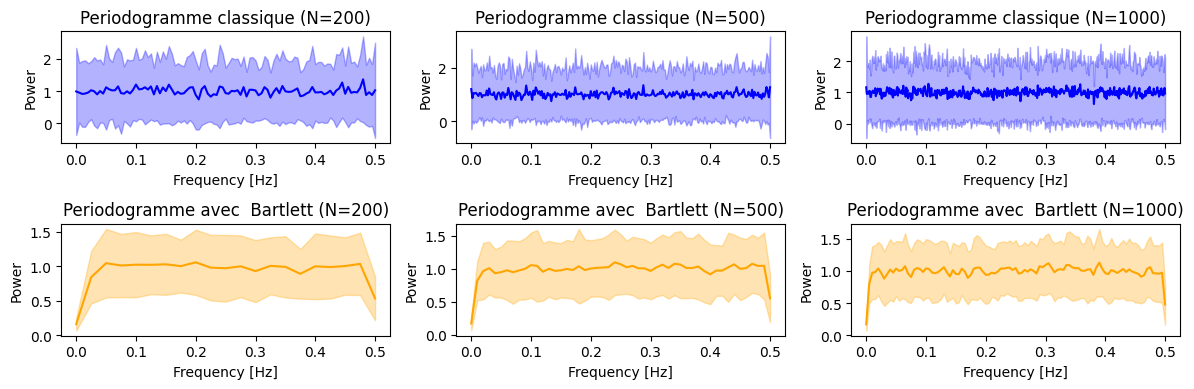

In [114]:

fig, axes = plt.subplots(2, len(N_values), figsize=(12, 4))

for i, N in enumerate(N_values):
    bartletts = []
    periodos = []

    for _ in range(n_sim):
        x = np.random.normal(0, sigma2, N)  # bruit blanc gaussien

        # Périodogramme avec méthode de bartlett
        f, Pxx = bartlett_method(x, fs=1.0, K=5)
        f0, Pxx0 = periodogram(x, fs=1.0)
        bartletts.append(Pxx)
        periodos.append(Pxx0)
       

    bartletts = np.array(bartletts)
    bartlett_mean = bartletts.mean(axis=0)
    bartlett_std = bartletts.std(axis=0)
    periodos = np.array(periodos)
    per_mean = periodos.mean(axis=0)
    per_std = periodos.std(axis=0)

    axes[0, i].plot(f0, per_mean, color='blue')
    axes[0, i].fill_between(f0, per_mean - per_std, per_mean + per_std,
                            color='blue', alpha=0.3)
    axes[0, i].set_title(f"Periodogramme classique (N={N})")
    axes[0, i].set_xlabel("Frequency [Hz]")
    axes[0, i].set_ylabel("Power")


    axes[1, i].plot(f, bartlett_mean, color='orange')
    axes[1, i].fill_between(f, bartlett_mean - bartlett_std, bartlett_mean + bartlett_std,
                            color='orange', alpha=0.3)
    axes[1, i].set_title(f"Periodogramme avec  Bartlett (N={N})")
    axes[1, i].set_xlabel("Frequency [Hz]")
    axes[1, i].set_ylabel("Power")

plt.tight_layout()
plt.show()


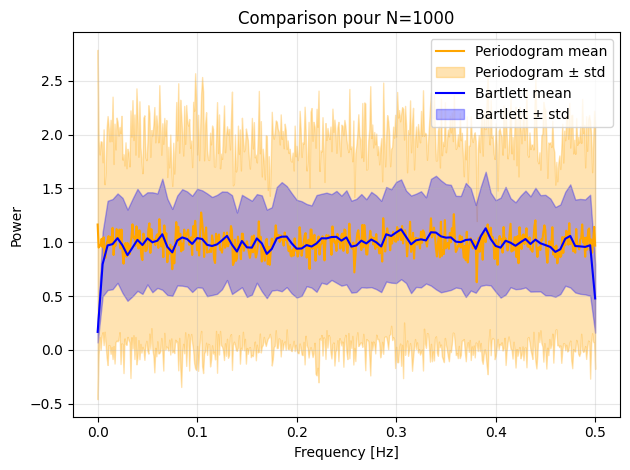

In [115]:
#sur le même graphique pour N=1000
plt.plot(f0, per_mean, color='orange', label='Periodogram mean')
plt.fill_between(f0, per_mean - per_std, per_mean + per_std,
                 color='orange', alpha=0.3, label='Periodogram ± std')

plt.plot(f, bartlett_mean, color='blue', label='Bartlett mean')
plt.fill_between(f, bartlett_mean - bartlett_std,bartlett_mean + bartlett_std,
                 color='blue', alpha=0.3, label='Bartlett ± std')

plt.title("Comparison pour N=1000")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

On observe qu'avec la méthode de Bartlett, on obtient un meilleur estimateur, plus stable (lisse) et avec une variance deux fois plus faible qu'avec le periodogramme classique. Le seul problème visible est au niveau des fréquences extremes (en 0 et 0.5) où on a des valeurs anormals.

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [116]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

AssertionError: The code 17-1 cannot be found in the data set.

## Question 10

In [ ]:
from dtw import dtw
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

In [ ]:
n_train = len(X_train)
dtw_train = np.zeros((n_train, n_train))

for i in range(n_train):
    for j in range(i+1, n_train):
        d = dtw(X_train[i], X_train[j])
        dtw_train[i, j] = d.distance
        dtw_train[j, i] = d.distance

In [ ]:
n_folds = 5
k_candidate = [1,3,5,7,9]  # mêmes k que GridSearchCV
best_k = None
best_f1 = -1

indices = np.arange(len(X_train))
np.random.seed(42)
np.random.shuffle(indices)
folds = np.array_split(indices, n_folds)

y_train_arr = np.array(y_train) 

for k in k_candidate:
    fold_scores = []
    for i in range(n_folds):
        val_idx = folds[i]
        train_idx = np.hstack([folds[j] for j in range(n_folds) if j != i])

        # Matrices de distances DTW pré-calculées
        Xtr = dtw_train[train_idx][:, train_idx]
        Xval = dtw_train[val_idx][:, train_idx]
        ytr, yval = y_train_arr[train_idx], y_train_arr[val_idx]

        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        knn.fit(Xtr, ytr)
        preds = knn.predict(Xval)
        fold_scores.append(f1_score(yval, preds))

    mean_f1 = np.mean(fold_scores)
    print(f"k={k}, F1={mean_f1:.3f}")

    if mean_f1 > best_f1:
        best_f1 = mean_f1
        best_k = k

print(f"Best k = {best_k}, F1 = {best_f1:.3f}")


ValueError: Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by KNeighborsClassifier.

In [ ]:

knn_dtw = KNeighborsClassifier(metric='precomputed')
np.random.seed(42)
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(knn_dtw, param_grid, scoring='f1', cv=cv, n_jobs=-1)
#grid_search = GridSearchCV(knn_dtw, param_grid, scoring='f1', cv=5, n_jobs=-1)

grid_search.fit(dtw_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

NameError: name 'KFold' is not defined

In [ ]:
n_test = len(X_test)
n_train = len(X_train)
dtw_test = np.zeros((n_test, n_train))

for i in range(n_test):
    for j in range(n_train):
        dtw_test[i, j] = dtw(X_test[i], X_train[j]).distance

knn_final = KNeighborsClassifier(n_neighbors=best_k, metric='precomputed')
knn_final.fit(dtw_train, y_train_arr)

y_pred = knn_final.predict(dtw_test)
test_f1 = f1_score(y_test, y_pred)

print(f"F1-score sur le test set : {test_f1:.3f}")

NameError: name 'X_test' is not defined

Au vu du F-score et du résultat obtenu sur les données tests on peut conclure à un overfitting sur les données d'entrainement, ce qui est un problème caractéristiques des K-means.
Le meilleur k trouvé est k = 1, ce qui signifie que le modèle ne considère qu’un seul voisin pour chaque prédiction. Cela rend le k-NN extrêmement sensible aux variations locales dans les données d’entraînement, ce qui explique un F1-score élevé sur le train mais beaucoup plus faible sur le test.
Cette situation est un comportement attendu pour des modèles basés sur les distances comme k-NN avec k faible : le modèle mémorise presque littéralement les exemples d’entraînement sans généraliser aux nouveaux pas

## Question 11

In [ ]:
misclassified_healthy = None
misclassified_nonhealthy = None

for idx, (true, pred) in enumerate(zip(y_test, y_pred)):
    if true == 0 and pred != true and misclassified_healthy is None:
        misclassified_healthy = idx
    elif true == 1 and pred != true and misclassified_nonhealthy is None:
        misclassified_nonhealthy = idx
    if misclassified_healthy is not None and misclassified_nonhealthy is not None:
        break

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(X_test[misclassified_healthy], color='blue')
plt.title("Badly classified Healthy step")
plt.xlabel("Time")
plt.ylabel("Signal value")

plt.subplot(1, 2, 2)
plt.plot(X_test[misclassified_nonhealthy], color='red')
plt.title("Badly classified Non-healthy step")
plt.xlabel("Time")
plt.ylabel("Signal value")

plt.suptitle("Figure 3: Examples of badly classified steps")
plt.tight_layout()
plt.show()

NameError: name 'y_test' is not defined